# CLIENT GEOGRAPHIC GROUPING USING K-MEANS ALGORITHM
```📚 October 1, 2022 by Julian Taglarini```

### INTRODUCTION

K-Means clustering is one of the most widely used unsupervised machine learning algorithms to form clusters of data based on the similarity between data instances. ```[1][2]```

### MOTIVATION
As I worked in a food proccessing and distribution company, I witness how often sales representatives use to group their clients pre sale visit based on their experience transformed into parameters like the day of the week when they are visited, sales volume, knowledge or "friendship" with the owner and so on.

We will use k-Means a an analitical aproach to that question and to establish a ground from wich the sales teams could start and then enhance client grouping using other factors besides their geographical location.

### LET'S BEGIN!

First, we need to import some packages in order to prepare our environment for work, which could be separated into two main tasks:
- Transform clients addresses into geographical coordinates.
- Process those geographical coordinates with k-Mean to find usefull or "ideal" client grouping.

In [2]:
# Packages needed to transform addresses into URLs, 
# and then into corresponding geographic coordinates
import openpyxl
import json
import time
import urllib.request
import urllib.parse
import os

# Packages needed for k-Means
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans

Note: For this study we will be using version 1.1.2 of Scikit-Learn package.

In [3]:
print(f'The scikit-learn version is {sklearn.__version__}')

The scikit-learn version is 1.1.2


Now we must load the data to analyze. I chose to do it from an Excel spreadsheet because it is the file import format of choice in our company ERP, but a .csv file could be used too.

In [4]:
arch = 'Nómina de Clientes'
clientes = pd.read_excel(f'./{arch}.xlsx', index_col=0,
                         na_values=[" "],
                         dtype={'cod_cliente': str, 'razon_social': str, 'domicilio': str, 'ciudad': str, 'cod_postal': str, 'provincia': str},
                         usecols=['cod_cliente', 'razon_social', 'domicilio', 'ciudad', 'cod_postal', 'provincia'])
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
010001,CLIENTE EJEMPLO 1,SAN LORENZO 52,Gaiman,9105,Chubut
010002,CLIENTE EJEMPLO 2,28 DE JULIO 641,Gaiman,9105,Chubut
010003,CLIENTE EJEMPLO 3,BROWN 928,Gaiman,9105,Chubut
010004,CLIENTE EJEMPLO 4,TELLO 643,Gaiman,9105,Chubut
010005,CLIENTE EJEMPLO 5,COM. ESPORA 21,Gaiman,9105,Chubut


If necessary, sales representatives could be required to complete all clients' data before beginning this analysis. Or, in the best case scenario, we cant develop an algorithm for searching their missing data address in the web, but this is out of this study scope.

For this present analisis I decided to eliminate rows with missing data, because for example it would be useless trying to find geographical coordinates of a non existent address or use the address of an anonimous client because of its name is missing.   

In [5]:
clientes.dropna(inplace=True)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
010001,CLIENTE EJEMPLO 1,SAN LORENZO 52,Gaiman,9105,Chubut
010002,CLIENTE EJEMPLO 2,28 DE JULIO 641,Gaiman,9105,Chubut
010003,CLIENTE EJEMPLO 3,BROWN 928,Gaiman,9105,Chubut
010004,CLIENTE EJEMPLO 4,TELLO 643,Gaiman,9105,Chubut
010005,CLIENTE EJEMPLO 5,COM. ESPORA 21,Gaiman,9105,Chubut


We also, in a simple way, will "normalize" cities' names...

In [6]:
clientes['ciudad'] = clientes.apply(lambda row: row['ciudad'].upper().strip(), axis=1)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
010001,CLIENTE EJEMPLO 1,SAN LORENZO 52,GAIMAN,9105,Chubut
010002,CLIENTE EJEMPLO 2,28 DE JULIO 641,GAIMAN,9105,Chubut
010003,CLIENTE EJEMPLO 3,BROWN 928,GAIMAN,9105,Chubut
010004,CLIENTE EJEMPLO 4,TELLO 643,GAIMAN,9105,Chubut
010005,CLIENTE EJEMPLO 5,COM. ESPORA 21,GAIMAN,9105,Chubut


...so we could filter clients by studied city, assuring us not to leave any result out because it didn't match for minor reasons (blank spaces after or before names or casing mismatch).

In [7]:
city = "'TRELEW'"
clientes = clientes.query('ciudad == '+ city)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut
020020,CLIENTE EJEMPLO 39,TRELEW,TRELEW,9100,Chubut
020031,CLIENTE EJEMPLO 50,MORENO 433,TRELEW,9100,Chubut
020041,CLIENTE EJEMPLO 60,BELGRANO 280 PISO 1,TRELEW,9100,Chubut
020051,CLIENTE EJEMPLO 70,BURMEISTER NTE 625,TRELEW,9100,Chubut


To use the Google Geocoding API first you must set up a Google Cloud project ```[3]``` and then obtain your own API key to use it.

Now we will add to the dataframe a column called 'url' and populate it with a function that will return a string containing our clients' address data formatted according to Google API requirements ```[4]``` to obtain its geolocalization later.

In [8]:
def create_url(row):
    # For security reasons please create an system environment
    # variable called 'MY_API_KEY' to store your Google
    # API key, then assign it to MY_API_KEY variable
    # DO NOT HARDCODE IT HERE!!! 
    MY_API_KEY = os.environ.get('MY_API_KEY')
    #
    GOG_URL_API = 'https://maps.googleapis.com/maps/api/geocode/json?address='

    # Code below is used if you like to keep in the study
    # customers with missing data in some or all address fields.
    # Since rows with 'NaN' values are purged in the previous
    # cell, this isn't necessary but is at your discretion.
    #
    # if type(row['Domicilio']) == float:
    #     row['Domicilio'] = ' '
    # if type(row['Localidad']) == float:
    #     row['Localidad'] = ' '
    # if type(row['Provincia']) == float:
    #     row['Provincia'] = ' '


    # If your customers table has a 'Country' column
    # or if you are using this in another country
    # replace 'Argentina' with the apropiate column or 
    # country name. For example:
    # add_str = row['Domicilio'] + ' ' + row['Localidad'] + ' ' + row['Provincia'] + ' ' + row['Pais']
    # or
    # add_str = row['Domicilio'] + ' ' + row['Localidad'] + ' ' + row['Provincia'] + ' Uruguay'
    #
    add_str = row['domicilio'] + ' ' + row['ciudad'] + ' ' + row['provincia'] + ' Argentina'
    address = {'address': add_str}
    url = GOG_URL_API + urllib.parse.urlencode(address) + '&key=' + MY_API_KEY
    return url

In [9]:
clientes['url'] = clientes.apply(lambda row: create_url(row), axis=1)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia,url
cod_cliente,,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...
020020,CLIENTE EJEMPLO 39,TRELEW,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...
020031,CLIENTE EJEMPLO 50,MORENO 433,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...
020041,CLIENTE EJEMPLO 60,BELGRANO 280 PISO 1,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...
020051,CLIENTE EJEMPLO 70,BURMEISTER NTE 625,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...


Finally, we create another function used to convert the previous generated address string into a geospatial point (latitude,longitude) thanks to Google geocoding API ```[4]```

In [10]:
def addr_to_coord(url):

    current_delay = 0.1  # Set the initial retry delay to 100ms.
    max_delay = 5  # Set the maximum retry delay to 5 seconds.

    while True:
        try:
            # Get the API response.
            response = urllib.request.urlopen(url)
        except urllib.error.URLError:
            pass  # Fall through to the retry loop.
        else:
            # If we didn't get an IOError then parse the result.
            result = json.load(response)

            if result["status"] == "OK":
                # return result["timeZoneId"]
                lat = result['results'][0]['geometry']['location']['lat']
                lng = result['results'][0]['geometry']['location']['lng']
                return lat,lng
            
            elif result["status"] != "UNKNOWN_ERROR":
                # Many API errors cannot be fixed by a retry, e.g. INVALID_REQUEST or
                # ZERO_RESULTS. There is no point retrying these requests.
                raise Exception(result["error_message"])

        if current_delay > max_delay:
            raise Exception("Too many retry attempts.")

        print("Waiting", current_delay, "seconds before retrying.")

        time.sleep(current_delay)
        current_delay *= 2  # Increase the delay each time we retry.

The returned coordinates for each location are stored in the dataframe as two new columns, one for its latitude ('lat') and one for its longitude ('long').

In [11]:
clientes['lat'], clientes['long']  = (clientes.apply(lambda row: addr_to_coord(row['url'])[0], axis=1), 
                                      clientes.apply(lambda row: addr_to_coord(row['url'])[1], axis=1))

Now with those recently created 'lat' and 'long' dataframe columns we will create a NumPy array as our input, to feed later the scikit-learn library 'k-Means' method.

In [12]:
la = np.array(clientes['lat'])
lo = np.array(clientes['long'])
X = np.column_stack((la,lo))

### Defining the Bounding Box

Now, to correctrly generate the image we will be using as background and also set the boundaries of all our geospatial points, we need to define our Bounding Box ```[5]```. 

The Bounding Box is an area defined by two longitudes and two latitudes which contain all our geospatial points, so we must obtain the maximun and minimun latitude and longitude from our dataframe.

In [13]:
bbox = ((clientes.long.min(),   clientes.long.max(),      
         clientes.lat.min(), clientes.lat.max()))
bbox

(-65.3582667, -65.27972179999999, -43.3014766, -43.2350134)

With this data we can now export an image from OpenStreetMap ```[5]``` and then load it to use later as a background of our geospatial graphs.

In [14]:
city_map = plt.imread('./map.jpg')

Now, we can show all the geospatial points in a map...

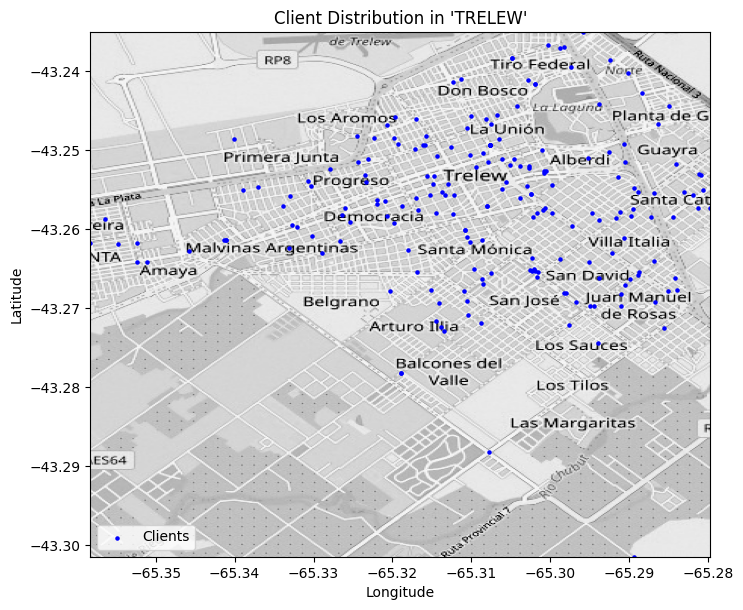

In [15]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(X[:,1], X[:,0], zorder=1, alpha= 1, c='b', s=5, label='Clients')
ax.set_title('Client Distribution in ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')

ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')


### Choosing the number of clusters

The K in K-Means comes from the number of clusters that need to be set prior to starting the iteration process.

This characteristic (setting the number of clusters beforehand) is sometimes seen as negative considering there are other clustering methods, such as Hierarchical Clustering, which don't need to have a fixed number of clusters beforehand.

But K-Means also has many advantages! It performs well on large datasets which can become difficult to handle if you are using some types of hierarchical clustering algorithms. It also guarantees convergence, and can easily generalize and adapt. 

Besides that, it is probably the most used clustering algorithm, so let's begin!

For example, here we choose k = 4:

In [17]:
n = 4
k_means = KMeans(n_clusters=n)
# k_means.fit(X[:,1],X[:,2])
k_means.fit(X)

KMeans(n_clusters=4)

Once executed the algorithm then we calculate the centroids and the labels

In [19]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

And now let us see our client clusters in a map!

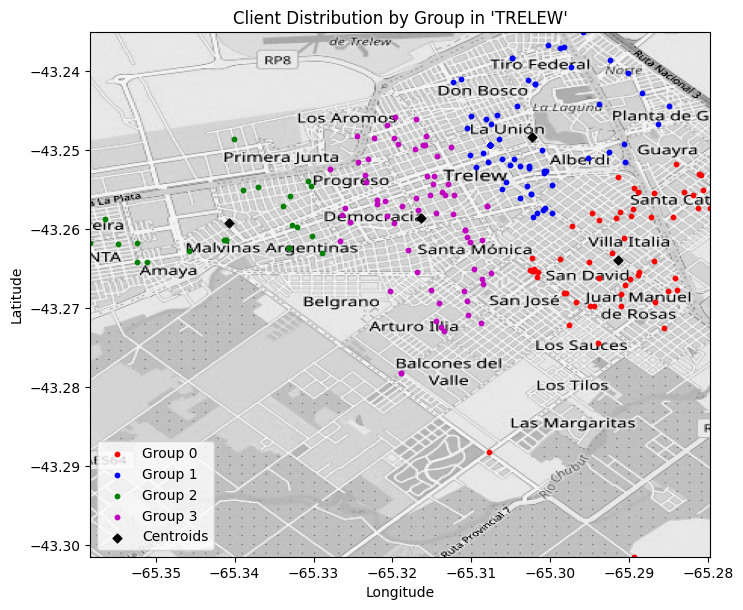

In [20]:
colores=['r','b','g','m', 'c', 'y']
fig, ax = plt.subplots(figsize = (8,7))
for i in range(0,n):
    ax.scatter(X[etiquetas==i,1],X[etiquetas==i,0],
               zorder=1, alpha= 1, c=f'{colores[i]}', s=10, label=f'Group {i}')

ax.scatter(centroides[:,1],centroides[:,0],
           marker='D', zorder=1, alpha= 1, c='k', s=20, label='Centroids')

ax.set_title('Client Distribution by Group in ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')

ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')

So far, so good! We've clustered our clients in the selected city, based on the Euclidean distance between points and centroids, in 4 clusters.

But... let's see how many clients are in each cluster:

In [21]:
n = 4
for g in range(0,n):
    print('The Grup nº', g, 'has', len(X[etiquetas==g,0]), 'clients.')

The Grup nº 0 has 54 clients.
The Grup nº 1 has 63 clients.
The Grup nº 2 has 22 clients.
The Grup nº 3 has 65 clients.


This client grouping seems univen...no? Did we actually make a mistake by choosing K=4 groups? Maybe we actually had K=5 groups? We could even have more than five groups and not be aware of it.

The question being asked here is how to determine the number of groups (K) in K-Means. To answer that question, we need to understand if there would be a "better" cluster for a different value of K. The naive way of finding that out is by clustering points with different values of K, so, for K=2, K=3, K=4, and so on.

But, clustering points for different Ks alone won't be enough to understand if we've chosen the ideal value for K. We need a way to evaluate the clustering quality for each K we've chosen.

Here is the ideal place to introduce a measure of how much our clustered points are close to each other and this measure is called WHITHIN CLUSTER SUM OF SQUARES, or WCSS for short. 

It essentially describes how much variance we have inside a single cluster so the smaller the WCSS is, the closer our points are, therefore we have a more well-formed cluster.

### Calculating WCSS
Fortunately, we don't need to manually calculate the WCSS for each K. After performing the K-Means clustering for the given nuber of clusters, we can obtain its WCSS by using Scikit-Learn KMeans method attribute "inertia_".

In [22]:
wcss = [] 
for number_of_clusters in range(2, 11): 
    kmeans = KMeans(n_clusters = number_of_clusters)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
wcss

[0.03904647846367816,
 0.026931566665443853,
 0.019531888493558622,
 0.01494401879886879,
 0.012280116054741063,
 0.010344851537411543,
 0.008657855678364659,
 0.00747138762439198,
 0.006326435448575218]

To visualize those results in order to use the Elbow method ```[6]```, let's plot our Ks along with the WCSS values.

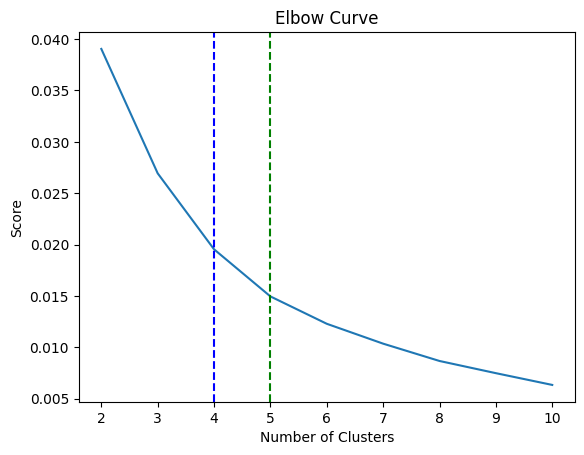

In [23]:
ks = range(2,11)
plt.plot(ks, wcss)
plt.axvline(4, linestyle='--', color='b')
plt.axvline(5, linestyle='--', color='g')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The curve obtained is really smooth so I consider 5 as a good number for K, but could be other more convenient based on your criterion.

So now we proceed to use 5 in the algorithm as the number of desired clusters...

In [24]:
n = 5
k_means = KMeans(n_clusters=n)
k_means.fit(X)

KMeans(n_clusters=5)

...and calculate corresponding centroids and labels.

In [25]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

Let's see again in a map how our groups are confomed now: 

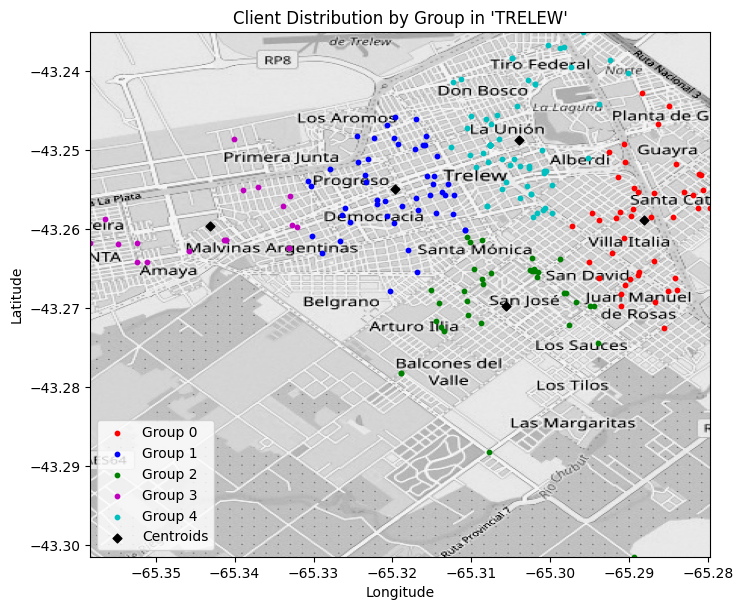

In [26]:
fig, ax = plt.subplots(figsize = (8,7))
for i in range(0,n):
    ax.scatter(X[etiquetas==i,1],X[etiquetas==i,0],
               zorder=1, alpha= 1, c=f'{colores[i]}', s=10, label=f'Group {i}')

ax.scatter(centroides[:,1],centroides[:,0],
           marker='D', zorder=1, alpha= 1, c='k', s=20, label='Centroids')

ax.set_title('Client Distribution by Group in ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')

ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')

And let's see how many clients are now in each cluster:

In [27]:
n = 5
for g in range(0,n):
    print(g, '=', len(X[etiquetas==g,0]))

0 = 43
1 = 48
2 = 35
3 = 18
4 = 60


Now, the only thing rest to do is create a column in the dataframe and fill it with the group number assigned to every client for later use.

In [30]:
cli1 = clientes.assign(grupo = etiquetas)
cli1.head()

,razon_social,domicilio,ciudad,cod_postal,provincia,url,lat,long,grupo
cod_cliente,,,,,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.257805,-65.291197,0
020020,CLIENTE EJEMPLO 39,TRELEW,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.249302,-65.307635,4
020031,CLIENTE EJEMPLO 50,MORENO 433,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.252024,-65.302702,4
020041,CLIENTE EJEMPLO 60,BELGRANO 280 PISO 1,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.251498,-65.307851,4
020051,CLIENTE EJEMPLO 70,BURMEISTER NTE 625,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.248534,-65.340039,3


For example let's see Group 0...

In [33]:
filtro = cli1['grupo'] == 0
grupo0 = cli1[filtro]
grupo0.head()

,razon_social,domicilio,ciudad,cod_postal,provincia,url,lat,long,grupo
cod_cliente,,,,,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.257805,-65.291197,0
020057,CLIENTE EJEMPLO 76,TIERRA DEL FUEGO 370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.266211,-65.293789,0
020078,CLIENTE EJEMPLO 97,MURGA 310,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.272462,-65.285633,0
020082,CLIENTE EJEMPLO 101,PATAGONIA 314 UPCN,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.268227,-65.291039,0
020101,CLIENTE EJEMPLO 120,AV. EVA PERON 1401,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,-43.255456,-65.286837,0


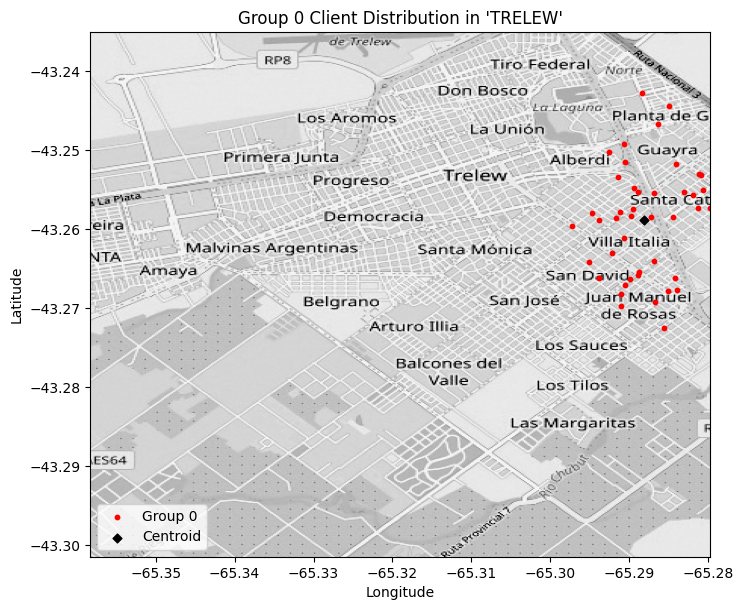

In [35]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(grupo0.long, grupo0.lat, zorder=1, alpha= 1, c=colores[0], s=10, label='Group 0')
ax.scatter(centroides[0,1],centroides[0,0], marker='D', zorder=1, alpha= 1, c='k', s=20, label='Centroid')
ax.set_title('Group 0 Client Distribution in ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')
ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')

## Contact:
<a href="mailto:jltaglia2@gmail.com?Subject=Hi%20Julian%20!">🖂 Mail</a>

[Github](https://www.Github.com/jltaglia)

[kaggle](https://www.kaggle.com/juliantagliarini)

## References:

- [1] k-Means algorithm for image classification and processing 

    <p>El algoritmo k-means aplicado a clasificación y procesamiento de imágenes</p>
    <p>Computación Numerica - Universidad de Oviedo - Departamento de Matemáticas.</p>
    
    https://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html

- [2] Definitive Guide to K-Means Clustering with Scikit-Learn

    <p>Cássia Sampaio - StackAbuse (Jul 07, 2022)</p>

    https://stackabuse.com/k-means-clustering-with-scikit-learn/

- [3] Set Up in the Google Cloud Console

    <p>How to set up your Google Cloud project before using the Google Maps Platform APIs.</p>

    https://developers.google.com/maps/documentation/geocoding/cloud-setup

- [4] Best Practices Using Geocoding API Web Services

    https://developers.google.com/maps/documentation/geocoding/web-service-best-practices?hl=en

- [5] Easy Steps To Plot Geographic Data on a Map — Python 

    <p>Ahmed Quassim - Towards Data Science (Aug 16, 2019)</p>
    
    https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db

    https://medium.com/@abuqassim115/thanks-for-your-response-frank-fb869824ede2

- [6] Elbow method (clustering) - Wikipedia

    https://en.wikipedia.org/wiki/Elbow_method_(clustering)